# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [4]:
import pandas as pd

In [5]:
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

In [6]:
# Load pickled data
import pickle

training_file = "traffic-sign-data/train.p"
testing_file = "traffic-sign-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [7]:
# Basic data summary.

n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Sample images


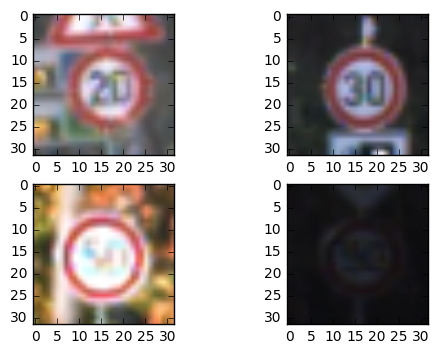

In [8]:
# Plot four sample images
print('Sample images')
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(X_train[i*1500+1])

[]

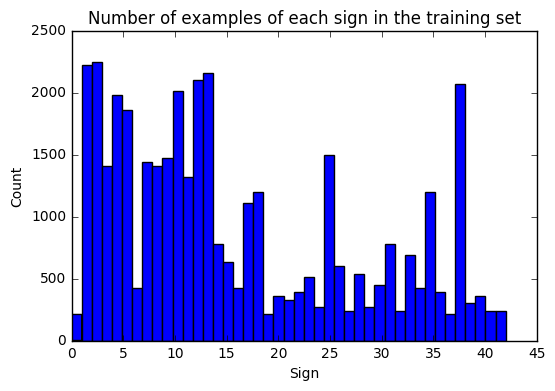

In [9]:
# Plot a histogram of the count of the number of examples of each sign
# in the test set

plt.hist(y_train, bins=n_classes)
plt.title('Number of examples of each sign in the training set')
plt.xlabel('Sign')
plt.ylabel('Count')
plt.plot()

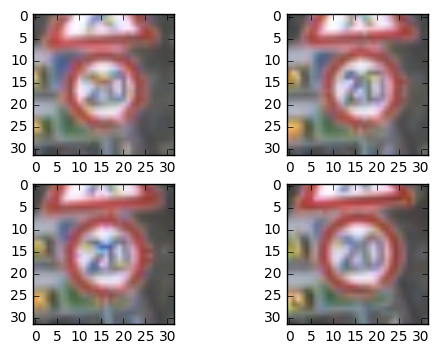

In [10]:
# TODO: Specify what this is for or remove
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(X_train[i])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### 2.1 Preprocess Data (includes shuffling)

In [11]:
# Shuffle training examples
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

#### 2.1.2 Normalisation

In [12]:
X_train_orig = X_train
X_test_orig = X_test

In [13]:
# Normalise input (images still in colour)
X_train = (X_train - X_train.mean()) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - X_test.mean()) / (np.max(X_test) - np.min(X_test))

In [14]:
def plot_norm_image(image_index):
    plt.subplot(2,2,1)
    plt.imshow(X_train_orig[image_index])
    plt.subplot(2,2,2)
    plt.imshow(X_train[image_index])

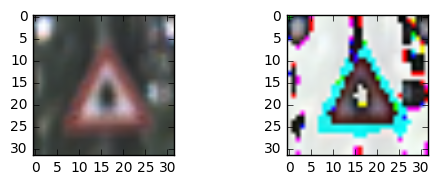

In [15]:
plot_norm_image(20)

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
* I decided not to grayscale the data because colours may be relevant. For example, a stop sign might be an upside-down red triangle, and knowing the colour of the triangle may help us predict the sign correctly. 
* I normalised the data. I [found that normalising the data (as opposed to standardising it) gives the higher validation and training accuracy for a two-layer feedforward network](https://github.com/jessicayung/self-driving-car-nd/blob/master/p2-traffic-signs/Comparison%20of%20model%20performance%20using%20original%2C%20standardised%20and%20normalised%20data.ipynb).

### 2.2 Split into training, validation and test sets

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2,
                                                  random_state=42)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

* Training and test data were already separated (downloaded pickled files `train.p` and `test.p`).
* I **shuffled the training data** because they were arranged in ascending order by label. If I don't shuffle the training data, the first series of batches will all be the first type of sign followed by the second type and so on. This will distort the learning process.
* I **further split the training data into test and valdiation sets** so the model wouldn't be cheating when we optimised it.
* **Improvement**: Generate additional data. The number of examples in the training data for each class is uneven, so the model may be biased towards predicting an unknown sign belongs to a class where there is abundant training data since we are minimising the training loss.

### 2.3 Model Architecture

In [17]:
# Network parameters
n_input = 32 * 32 * 3
nb_filters = 32
kernel_size = (3, 3)
input_shape = (32, 32, 3)
n_fc1 = 512
n_fc2 = 128
in_channels = 3
pool_size = 2 # i.e. (2,2)

In [18]:
# tf Graph input
x_unflattened = tf.placeholder("float", [None, 32, 32, 3])
x = x_unflattened

y_rawlabels = tf.placeholder("int32", [None])
y = tf.one_hot(y_rawlabels, depth=43, on_value=1., off_value=0., axis=-1)

In [25]:
## Create model

def conv2d(x, W, b, strides=3):
    # Conv2D wrapper, with bias and relu activation
    # strides = [batch, in_height, in_width, channels]
    # TODO: Explain these parameters
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2, padding_setting='SAME'):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding=padding_setting)

def conv_net(model_x, model_weights, model_biases, model_pool_size, 
             model_dropout_conv, model_dropout_fc, padding='SAME'):
    # Convolution Layer 1
    conv1 = conv2d(model_x, model_weights['conv1'], model_biases['conv1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=model_pool_size, padding_setting=padding)
    conv1 = tf.nn.dropout(conv1, model_dropout_conv)

    # Fully connected layer 1
    # Reshape conv1 output to fit fully connected layer input
    conv1_shape = conv1.get_shape().as_list()
    print("Conv1 Shape: ", conv1_shape)
    fc1 = tf.reshape(conv1, [-1, conv1_shape[1]*conv1_shape[2]*conv1_shape[3]])
    fc1 = tf.add(tf.matmul(fc1, model_weights['fc1']), model_biases['fc1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, model_dropout_fc)
    # Fully connected layer 2
    fc2 = tf.add(tf.matmul(fc1, model_weights['fc2']), model_biases['fc2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, model_dropout_fc)
    # Output layer
    output = tf.add(tf.matmul(fc2, model_weights['out']), model_biases['out'])
    # Note: Softmax is outside the model
    return output


## Store layers weight & bias

# NEW: initialise neurons with slightly positive initial bias
# to avoid dead neurons.
def weight_variable(shape, weight_mean, weight_stddev):
    initial = tf.truncated_normal(shape, stddev=weight_stddev, mean=weight_mean)
    # alt: tf.random_normal(shape)
    return tf.Variable(initial)


def bias_variable(shape, bias_mean):
    initial = tf.constant(bias_mean, shape=shape)
    return tf.Variable(initial)


weights = {
    'conv1': weight_variable([kernel_size[0], kernel_size[1], in_channels, nb_filters], weights_mean, weights_stddev),
    # TODO: Convert line below to not-hardcoded. Prev was nb_filters
    # 1152 = 3**2 * 2**7
    # 800 = 5 * 5 * 32
    'fc1': weight_variable([1152, n_fc1], weights_mean, weights_stddev),
    'fc2': weight_variable([n_fc1, n_fc2], weights_mean, weights_stddev),
    'out': weight_variable([n_fc2, n_classes], weights_mean, weights_stddev)
}

biases = {
    'conv1': bias_variable([nb_filters], biases_mean),
    'fc1': bias_variable([n_fc1], biases_mean),
    'fc2': bias_variable([n_fc2], biases_mean),
    'out': bias_variable([n_classes], biases_mean)
}

References: 
https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/multilayer_perceptron.py


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**



* My final architecture is a 3-layer Convolutional Neural Network.
* It consists of one convolution layer (feature extraction) followed by two fully connected layers (ReLU activation) and a single fully connected linear classifier.
* The network uses full colour information (all three channels) and normalised data.

References:
* The code is based on [Aymeric Damien's implementation of a CNN in TensorFlow](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py).

### 2.4 Training the model

In [26]:
# Training parameters
learning_rate = 0.001
initial_learning_rate = learning_rate
training_epochs = 100
batch_size = 100
display_step = 1
n_train = len(X_train)

dropout_conv = 0.5
dropout_fc = 0.2

padding = 'SAME'

weights_stddev = 0.1
weights_mean = 0.0
biases_mean = 0.0

anneal_mod_frequency = 15
# Annealing rate of 1: learning rate remains constant.
annealing_rate = 1

print_accuracy_mod_frequency = 1

# Construct model
pred = conv_net(x, weights, biases, pool_size, dropout_conv, dropout_fc, padding='SAME')
pred_probs = tf.nn.softmax(pred)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Function to initialise the variables
init = tf.initialize_all_variables()

### RUN MODEL ###
# Launch the graph
sess = tf.Session()

# Initialise variables
sess.run(init)

# Initialise time logs
init_time = time.time()
epoch_time = init_time

# Training cycle
for epoch in range(training_epochs):
    avg_cost = 0.

    total_batch = int(n_train / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_x, batch_y = np.array(X_train[i * batch_size:(i + 1) * batch_size]), \
                           np.array(y_train[i * batch_size:(i + 1) * batch_size])
        # tf.train.batch([X_train, y_train], batch_size=100, enqueue_many=True)
        # Run optimization op (backprop) and cost op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={x_unflattened: batch_x, y_rawlabels: batch_y})
        # Compute average loss
        avg_cost += c / total_batch
        # print(avg_cost)
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch + 1), "cost=",
              "{:.9f}".format(avg_cost))
        last_epoch_time = epoch_time
        epoch_time = time.time()
        print("Time since start: ", epoch_time - init_time)
        print("Time since last epoch: ", epoch_time - last_epoch_time)
    # Anneal learning rate
    if (epoch + 1) % anneal_mod_frequency == 0:
        learning_rate *= annealing_rate
        print("New learning rate: ", learning_rate)

    if (epoch + 1) % print_accuracy_mod_frequency == 0:
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        # Line below needed only when not using `with tf.Session() as sess`
        with sess.as_default():
            print("Accuracy (validation):", accuracy.eval({x_unflattened: X_val, y_rawlabels: y_val}))

print("Optimization Finished!")

# Test model
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
# Calculate accuracy
# accuracy_train = tf.reduce_mean(tf.cast(correct_prediction, "float"))
# print("Accuracy (train):", accuracy_train.eval({x_unflattened: X_train, y_rawlabels: y_train}))
train_predict_time = time.time()
# print("Time to calculate accuracy on training set: ", train_predict_time - epoch_time)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
# Line below needed only when not using `with tf.Session() as sess`
with sess.as_default():
    print("Accuracy (test):", accuracy.eval({x_unflattened: X_test, y_rawlabels: y_test}))
test_predict_time = time.time()
print("Time to calculate accuracy on test set: ", test_predict_time - train_predict_time)

# Print parameters for reference
print("\nParameters:")
print("Learning rate (initial): ", initial_learning_rate)
print("Anneal learning rate every ", anneal_mod_frequency, " epochs by ", 1 - annealing_rate)
print("Learning rate (final): ", learning_rate)
print("Training epochs: ", training_epochs)
print("Batch size: ", batch_size)
print("Dropout (conv): ", dropout_conv)
print("Dropout (fc): ", dropout_fc)
print("Padding: ", padding)
print("weights_mean: ", weights_mean)
print("weights_stddev: ", weights_stddev)
print("biases_mean: ", biases_mean)

Conv1 Shape:  [None, 6, 6, 32]
Epoch: 0001 cost= 3.633297085
Time since start:  1.977123737335205
Time since last epoch:  1.977123737335205
Accuracy (validation): 0.0992094
Epoch: 0002 cost= 3.180818480
Time since start:  4.2330169677734375
Time since last epoch:  2.2558932304382324
Accuracy (validation): 0.200459
Epoch: 0003 cost= 2.661614267
Time since start:  6.35676383972168
Time since last epoch:  2.123746871948242
Accuracy (validation): 0.267151
Epoch: 0004 cost= 2.347705019
Time since start:  8.409562826156616
Time since last epoch:  2.0527989864349365
Accuracy (validation): 0.304514
Epoch: 0005 cost= 2.180301807
Time since start:  10.414836645126343
Time since last epoch:  2.0052738189697266
Accuracy (validation): 0.320964
Epoch: 0006 cost= 2.094434197
Time since start:  12.395683765411377
Time since last epoch:  1.9808471202850342
Accuracy (validation): 0.336776
Epoch: 0007 cost= 2.033652549
Time since start:  14.324381828308105
Time since last epoch:  1.9286980628967285
Accur

**Deprecated code**:
* Potential alternantive for batching:
`tf.train.batch([X_train, y_train], batch_size=100, enqueue_many=True)
`

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

TODO: Optimise network s.t. it gives over 99% performance. Look at models used in Keras versions. 
TODO: Update these answers to reflect new network.

* Type of optimiser: AdamOptimizer
* Batch size: 100
* Training Epochs: 15
* Learning rate: 0.01
* Dropout: 0.75
* n_hidden_1 = 256 # 1st layer number of features
* n_hidden_2 = 256 # 2nd layer number of features

*Aside*:

Additional info on AdamOptimizer from [StackOverflow](http://stats.stackexchange.com/questions/184448/difference-between-gradientdescentoptimizer-and-adamoptimizer-tensorflow) (mrry):
* tf.train.AdamOptimizer uses Kingma and Ba's Adam algorithm to control the learning rate. 
* Main advantage of Adam over the simple `tf.train.GradientDescentOptimizer`:
    * Uses moving averages of the parameters (momentum) -> enables Adam to use a larger effective step size, and the algorithm will converge to this step size without fine tuning. 
        * Bengio discusses the reasons for why this is beneficial in Section 3.1.1 of [this paper](http://arxiv.org/pdf/1206.5533.pdf). 
    * A simple tf.train.GradientDescentOptimizer would require more hyperparameter tuning before it would converge as quickly.'

* Disadvantage: 
    * Adam requires more computation to be performed for each parameter in each training step (to maintain the moving averages and variance, and calculate the scaled gradient); and more state to be retained for each parameter (approximately tripling the size of the model to store the average and variance for each parameter). 


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

**1. First attempt: building a minimum viable model and debugging**
- I wanted to get a working model first. I started with a basic multilayer perceptron which I adapted from `TensorFlow-Examples`. I trained it for 15 epochs, which had an accuracy of 6% on the training and test sets. I then trained a two-layer convolutional neural network for 15 epochs which had an accuracy of 5-6% on the training and test sets. 
    - The accuracy was lower than I expected and the cost seemed high (of order 10^6 in the first epoch, 10^5 in the second and third and in the hundreds in the tenth epoch), so I adjusted parameters hoping to improve it before training for longer.
    - The cost reduced significantly (to single digits by the second epoch as opposed to order 10^5) after I added a small positive bias to the initial weights and biases. Strangely, the accuracy did not increase, but remained at 5-6%. The cost did not decrease significantly over the next 10 epochs either.
    - I went on Slack to see what results people were getting to get a feel for how wrong I was. I saw that people often trained their networks for hundreds of epochs so I thought it would be good to train my network for e.g. 100 epochs.
- I rewrote the multilayer perceptron in a Python Script and it worked fine, returning an accuracy of over 70% accuracy within 2 epochs.
- This model had TODO: ADD % accuracy after 15 epochs.

**2. Improvements to the model**
- I then added a convolution layer before the two fully connected layers and the output layer.
- This new model produced an accuracy of TODO: ADD % after 15 epochs (parameters not tuned).

** 3. Comparisons**
- I compared this model with adding TODO: Continue
- I used Keras to implement comparisons so I could get full figures on training and validation loss and accuracy easily.
- Since the previous model gave training and testing accuracies I was satisfied with and was better than simply adding more convolution layers, I chose that model.

** Tuning parameters**
- TODO: ADD

---
## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### 3.1 New Images and the Model's Predictions

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._

**Answer:**

(Special characteristics of images are noted in the comments)

In [ ]:
# Helper function to read image copied from lane lines project
def read_image_and_print_dims(image_path):
    """Reads and returns image.
    Helper function to examine how an image is represented.
    """
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

In [ ]:
# This sign is not in English. It is a stop sign.
# There are multiple signs in the picture. 
# What wil the model attempt to recognise?
japanese_sign = read_image_and_print_dims('traffic-sign-data/japanese-sign.jpg')

In [ ]:
# There is other intervening text in the image.
# This sign is shown at an angle.
german_sign = read_image_and_print_dims('traffic-sign-data/german-sign.jpg')

In [ ]:
# This sign is quite clear.
two_way_sign = read_image_and_print_dims('traffic-sign-data/two-way-sign.jpg')

In [ ]:
# Can the model recognise the 20 km/h sign as a speed limit sign
# even though it has different background colour, different shape
# and additional 'km/h' text?
speed_limit_stop = read_image_and_print_dims('traffic-sign-data/speed-limit-stop.JPG')

In [ ]:
# What will the model think this is?
shark_sign = read_image_and_print_dims('traffic-sign-data/shark-sign.jpg')

In [ ]:
shark_sign.shape

In [ ]:
shark_sign_cropped = shark_sign[:,:1298,:]

In [ ]:
shark_sign_cropped.shape

In [ ]:
# shark_sign_cropped.reshape(28,28)
shark_sign_reshaped = cv2.resize(shark_sign_cropped, (32,32))

In [ ]:
shark_sign_reshaped.shape

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
def predict(img):
    classification = sess.run(tf.argmax(pred, 1), feed_dict={x_unflattened: [img]})
    print(classification)
    print('NN predicted', classification[0])

In [ ]:
predict(shark_sign_reshaped)

In [ ]:
def show_and_pred_X_train(index):
    plt.imshow(X_train[index])
    predict(X_train[index])

In [ ]:
show_and_pred_X_train(40)

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

TODO: Complete Q7 (captured pictures performance vs dataset)

My guess would be no because
1. Live camera stream is not limited to 32 x 32 images.
2. Images not included in the dataset are not exactly the same road signs so there is additional difficulty because the model needs to generalise well to classify these new signs correctly.


In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


In [ ]:
# TODO: Answer Q8 (visualise certainty of predictions)

**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**
Not applicable at the moment.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.